In [156]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
random.seed(42)

# Функция для создания бутстрап-выборок
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        
        b_data = data[indices]
        b_labels = labels[indices]
        
        bootstrap.append((b_data, b_labels))

    return bootstrap

# Функция для выбора случайного подмножества признаков
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    
    subsample = random.sample(sample_indexes, len_subsample)
    
    return subsample

In [158]:
# Реализуем класс узла
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# Реализуем класс листа
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        if len(self.labels) == 0:
            return 0
        
        unique, counts = np.unique(self.labels, return_counts=True)
        return unique[np.argmax(counts)]

# Расчёт критерия Джини
def gini(labels):
    if len(labels) == 0:
        return 0
    
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    impurity = 1.0 - np.sum(probabilities ** 2)
    
    return impurity
# Расчёт качества разбиения
def quality(left_labels, right_labels, current_gini):
    p = float(len(left_labels)) / (len(left_labels) + len(right_labels))
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение выборки на две части
def split(data, labels, index, t):
    mask = data[:, index] <= t
    
    true_data = data[mask]
    false_data = data[~mask]
    true_labels = labels[mask]
    false_labels = labels[~mask]
    
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels, feature_indices=None):
    # Минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    n_samples, n_features = data.shape
    
    if feature_indices is None:
        feature_indices = range(n_features)
    
    for index in feature_indices:
        feature_values = np.unique(data[:, index])
        
        if len(feature_values) < 2:
            continue
        
        feature_values_sorted = np.sort(feature_values)
        
        thresholds = (feature_values_sorted[:-1] + feature_values_sorted[1:]) / 2
        
        if len(thresholds) == 0:
            continue
        
        for t in thresholds:
            mask = data[:, index] <= t
            
            n_true = np.sum(mask)
            n_false = n_samples - n_true
            
            if n_true < min_leaf or n_false < min_leaf:
                continue
            
            true_labels = labels[mask]
            false_labels = labels[~mask]
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index
    
    return best_quality, best_t, best_index

# Построение дерева посредством рекурсивной функции
def build_tree(data, labels, feature_indices=None, depth=0, max_depth=10):
    # Критерии остановки
    if (len(np.unique(labels)) == 1 or 
        len(labels) < 2 or 
        depth >= max_depth):
        return Leaf(data, labels)
    
    n_features = data.shape[1]
    feature_indices = get_subsample(n_features)
    
    # Находим лучшее разбиение только по выбранным признакам
    quality, t, index = find_best_split(data, labels, feature_indices)
    
    # Базовый случай - прекращаем рекурсию, когда нет прироста в качестве
    if quality == 0 or index is None:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, feature_indices, depth + 1, max_depth)
    false_branch = build_tree(false_data, false_labels, feature_indices, depth + 1, max_depth)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [159]:
# Функция построения случайного леса
def random_forest(data, labels, n_trees, max_depth=20):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    n_features = data.shape[1]
    
    for i in range(n_trees):
        b_data, b_labels = bootstrap[i]

        tree = build_tree(b_data, b_labels, max_depth=max_depth)
        forest.append(tree)
        
        if (i + 1) % 10 == 0:
            print(f"Построено деревьев: {i + 1}/{n_trees}")
    
    return forest

# Функция классификации отдельного объекта
def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# Функция формирования предсказания по выборке на одном дереве
def predict(tree, data):
    classes = []
    
    for obj in data:
        classes.append(classify_object(obj, tree))
    
    return np.array(classes)

def numpy_mode(arr):
    if len(arr) == 0:
        return 0
    
    unique, counts = np.unique(arr, return_counts=True)
    return unique[np.argmax(counts)]

# Предсказание голосованием деревьев
def tree_vote(forest, data):
    n_trees = len(forest)
    n_samples = len(data)
    
    predictions_matrix = np.zeros((n_samples, n_trees), dtype=int)
    
    for i, tree in enumerate(forest):
        predictions_matrix[:, i] = predict(tree, data)
    
    voted_predictions = np.zeros(n_samples, dtype=int)
    
    for i in range(n_samples):
        obj_predictions = predictions_matrix[i, :]
        
        voted_predictions[i] = numpy_mode(obj_predictions)
    
    return voted_predictions


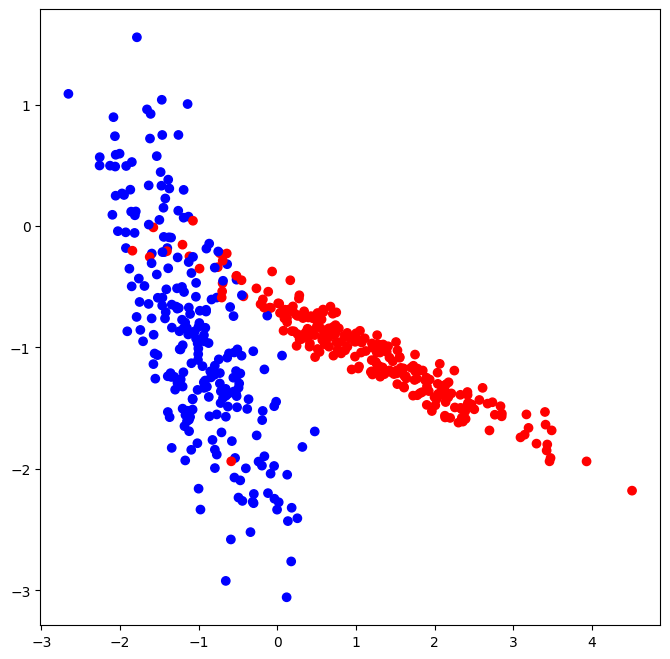

In [160]:
# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [161]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [162]:
 # Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [163]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 93.429
Точность случайного леса из 1 деревьев на тестовой выборке: 90.667


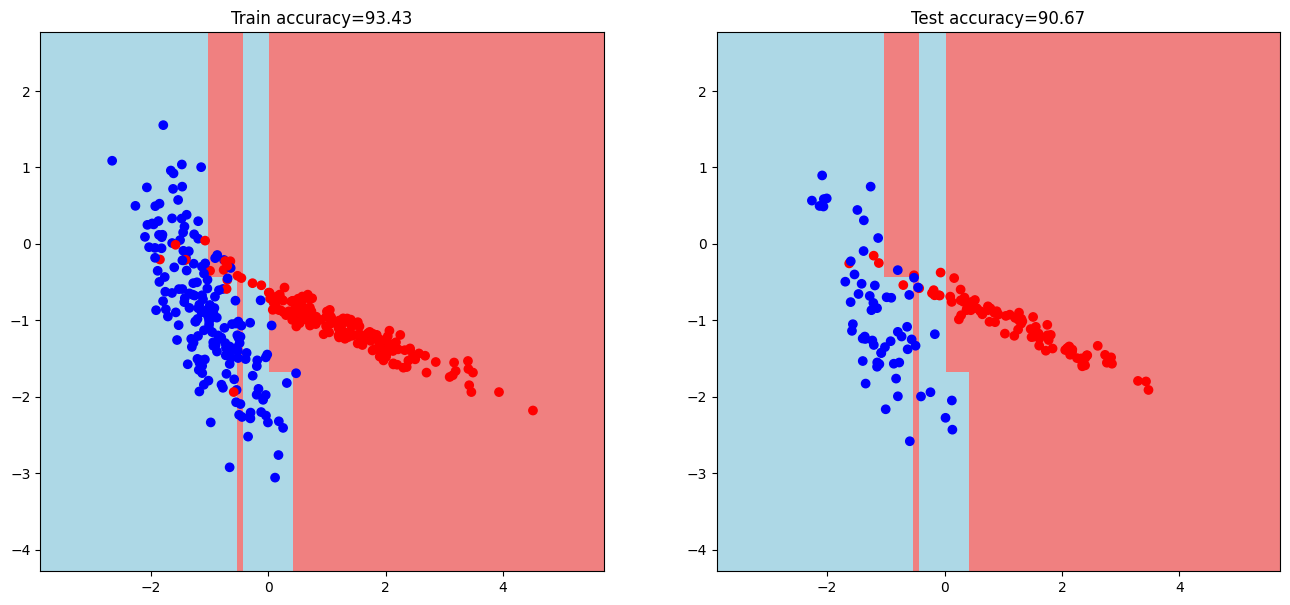

In [164]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [ ]:
n_trees = 50
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Построено деревьев: 10/50
Построено деревьев: 20/50
Построено деревьев: 30/50
Построено деревьев: 40/50
Построено деревьев: 50/50
Точность случайного леса из 50 деревьев на обучающей выборке: 96.571
Точность случайного леса из 50 деревьев на тестовой выборке: 93.333


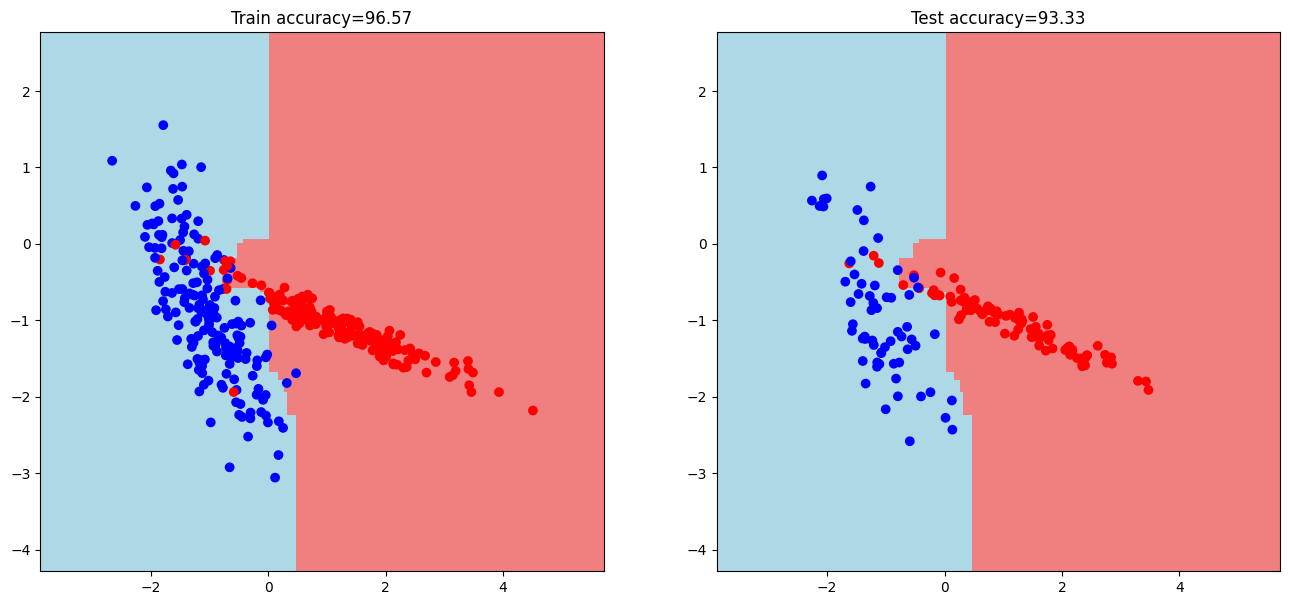

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()
